### torch.autograd

torch.autograd.backward

功能：自动求取梯度

tensors：用于求导的张量，如loss

retain_graph：保存计算图

create_graph：创建导数计算图，用于高阶求导

grad_tensors：多梯度权重

In [3]:
import torch

w = torch.tensor([1.],requires_grad = True)
x = torch.tensor([2.],requires_grad = True)

a = torch.add(w,x)
#保存非叶子节点梯度
a.retain_grad()
b = torch.add(w,1)
y = torch.mul(a,b)

y.backward()
print(w.grad)

tensor([5.])


torch.autograd.grad

功能：求取梯度

outputs：用于求导的张量，如loss

inputs：需要梯度的张量

create_graph：创建导数计算图，用于高阶求导

retain_graph：保存计算图

grad_outputs：多梯度权重

In [12]:
x = torch.tensor([3.],requires_grad = True)
y = torch.pow(x,2)
grad_1 = torch.autograd.grad(y,x,create_graph=True,retain_graph=True)
grad_1

(tensor([6.], grad_fn=<MulBackward0>),)

In [13]:
grad_2 = torch.autograd.grad(grad_1[0],x)
grad_2

(tensor([2.]),)

autograd小贴士： 
1. 梯度不自动清零
2. 依赖于叶子结点的结点，requires_grad默认为True 
3. 叶子结点不可执行in-place(反向传播会需要叶子节点的内存地址里的数据)

### 逻辑回归
二分类模型
sigmoid函数（0，1）

数据
模型
损失函数
迭代训练
优化器

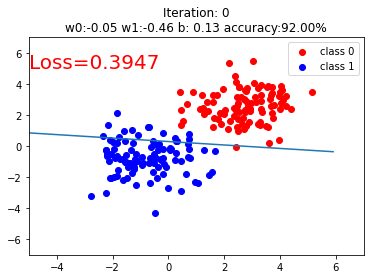

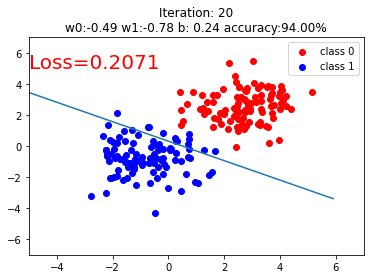

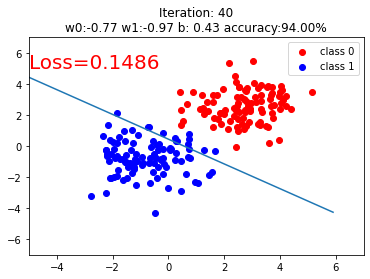

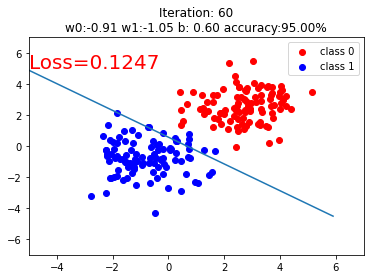

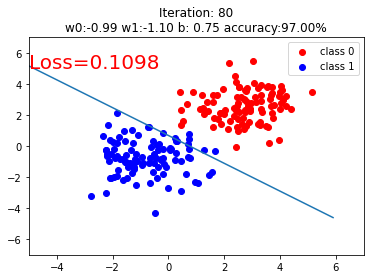

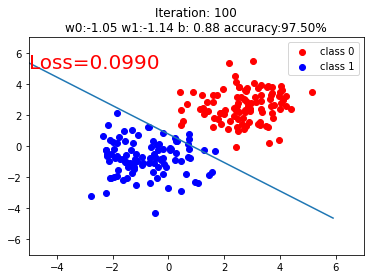

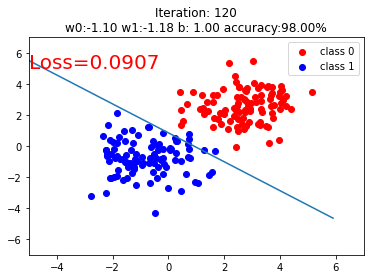

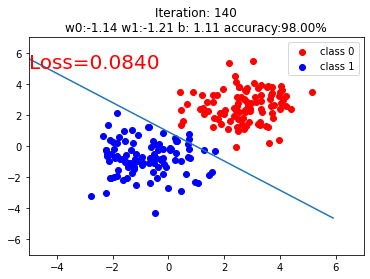

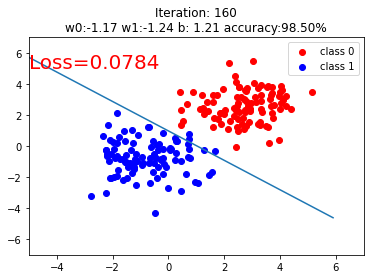

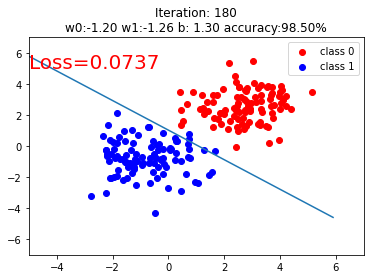

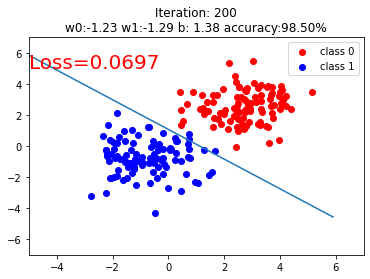

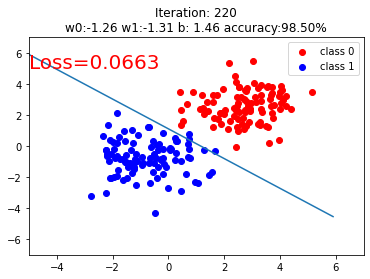

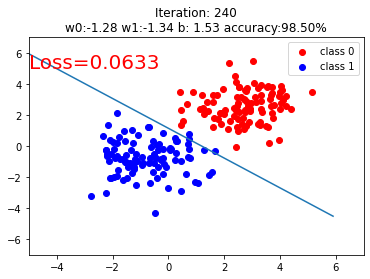

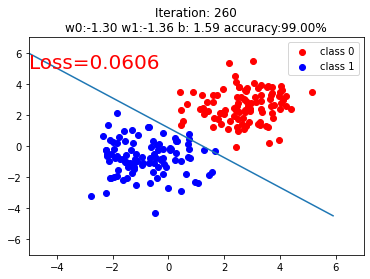

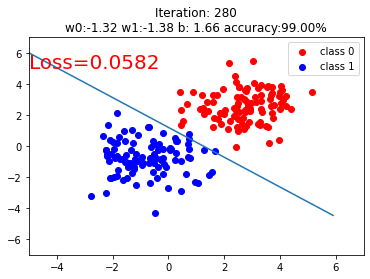

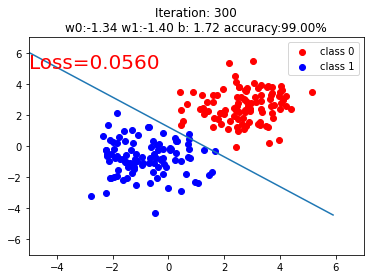

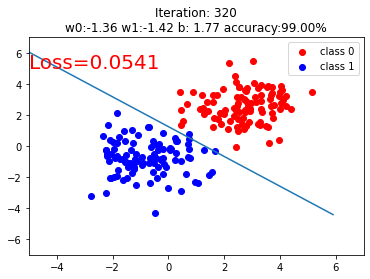

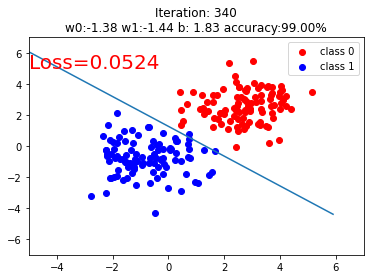

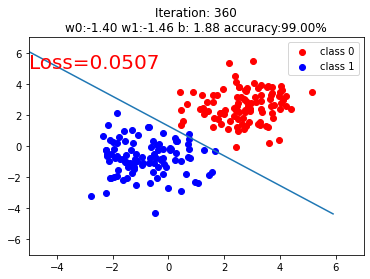

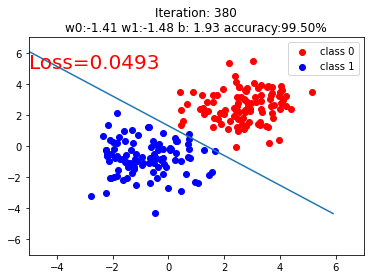

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)


# ============================ step 1/5 生成数据 ============================
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100)
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)


# ============================ step 2/5 选择模型 ============================
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()   # 实例化逻辑回归模型


# ============================ step 3/5 选择损失函数 ============================
loss_fn = nn.BCELoss()

# ============================ step 4/5 选择优化器   ============================
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

# ============================ step 5/5 模型训练 ============================
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)

    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)

    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 清空梯度
    optimizer.zero_grad()

    # 绘图
    if iteration % 20 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break